# 3.5: Cubic Splines

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Recall that the *natural cubic spline interpolant* for a set of $n+1$ data points
$$\lbrace(x_0,y_0), (x_1,y_1), \ldots,(x_n,y_n)\rbrace$$
is a set of $n$ cubic polynomials of the form $$S_j(x) = a_j + b_j(x - x_j) + c_j(x - x_j)^2 + d_j (x - x_j)^3, \quad \text{for } j = 0, 1, \ldots n-1.$$

Based on our discussion in class, we showed that if we define $$h_j = x_{j+1} - x_j, \quad \text{for } j = 0, 1, \ldots n-1$$ then, we could solve for $\lbrace a_j, b_j, c_j, d_j\rbrace$ via the following:

* $\displaystyle a_j = y_j, \quad \text{for } j = 0, 1, \ldots n$
* $\displaystyle b_j = \frac{1}{h_{j-1}}(a_j - a_{j-1}) - \frac{h_{j-1}}{3}(2c_{j-1}+c_j) \quad \text{for } j = 0, 1, \ldots n$
* $\displaystyle d_j = \frac{c_{j+1}-c_j}{3h_j}\quad \text{for } j = 0, 1, \ldots n$.


Of course, the above require us to determine $c_j$ for $j = 0, 1, \ldots n$.  To find these, we showed that we could form the natural cubic spline interpolant by solving the system $A\vec{x}= \vec{b}$, where 

$$A = \begin{bmatrix}
1 & 0 & 0 & &\cdots&&&&0\\
h_0 & 2(h_0 + h_1) & h_1 & & & & &&0\\
0 & h_1 & 2(h_1 + h_2) & h_2 & & & & &0\\ & & \ddots\\
\vdots & &&&&&&&&\\ \\
0 & & & &&& 0 & 0 & 1\end{bmatrix},\qquad  \vec{x} = \begin{bmatrix}c_0\\c_1\\ \vdots\\c_n\end{bmatrix},\quad \text{and}$$ 
$$\vec{b} = \begin{bmatrix} 0\\ \frac{3}{h_1}(a_2 - a_1) - \frac{3}{h_0}(a_1 - a_0)\\ \vdots \\\frac{3}{h_{n-1}}(a_{n} - a_{n-1}) - \frac{3}{h_{n-2}}(a_{n-1} - a_{n-2})\\0 \end{bmatrix}$$



We are going to need to build the matrix `A` as well as the vector `b` in order to solve for the coefficients $c_j$.  Using numpy, there are a few easy ways to build the matrix `A`.  The simpliest is as the sum of three matrices with the vectors defined as either on the diagonal (`0`), above the diagonal (`+1`), or below the diagonal (`-1`) using the command `np.diag()` (see [NumPy diag() documentation](https://docs.scipy.org/doc/numpy-1.16.1/reference/generated/numpy.diag.html)).  Thus, given two numpy arrays `xvals` and `yvals`, we can create `h` as well as the matrix `A` via the following commands:
```
    h = xvals[1:]-xvals[0:-1]                # creates an array of x_{j+1} - x_j
    
    d0 = np.hstack([1,2*(h[0:-1]+h[1:]),1])  # main diagonal array
    d1 = np.hstack([0,h[1:]])                # above the diagonal array
    dm1 = np.hstack([h[0:-1],0])             # below the diagonal array

    A = np.diag(d0) + np.diag(d1,1)+ np.diag(dm1,-1)
```

Likewise, we can use the `np.linalg.solve()` command to solve the system $A\vec{x} = \vec{b}$ as defined above.  Finally, we can use the formula to determine the remainder of the coefficients.  

Here is a list of the numpy commands that are helpful and used throughout the script
* [NumPy hstack()](https://docs.scipy.org/doc/numpy-1.16.1/reference/generated/numpy.hstack.html)
* [NumPy vstack()](https://docs.scipy.org/doc/numpy-1.16.1/reference/generated/numpy.vstack.html)
* [NumPy diag()](https://docs.scipy.org/doc/numpy-1.16.1/reference/generated/numpy.diag.html)
* [NumPy size()](https://docs.scipy.org/doc/numpy-1.16.1/reference/generated/numpy.generic.size.html)
* [NumPy linalg.solve()](https://docs.scipy.org/doc/numpy-1.16.1/reference/generated/numpy.linalg.solve.html)


In [5]:
def cubic_spline_coeffs(xvals,yvals):

    n = xvals.size - 1
    h = xvals[1:]-xvals[0:-1]

    d0 = np.hstack([1,2*(h[0:-1]+h[1:]),1])
    d1 = np.hstack([0,h[1:]])
    dm1 = np.hstack([h[0:-1],0])
    # create the "A" matrix by using the np.diag command
    A = np.diag(d0) + np.diag(d1,1)+ np.diag(dm1,-1)

    
    # create the right-hand-side of A*x = b
    # recall that a_j = y_j
    aVec = yvals
    rhs = np.hstack([0,(3./h[1:])*(aVec[2:]-aVec[1:-1])-(3/h[0:-1])*(aVec[1:-1]-aVec[0:-2]),0])
    
    # use the linalg.solve command to solve Ax = b  
    cVec = np.linalg.solve(A,rhs)

    
    # use the remaining formula to determine d_j and b_j
    dVec = (cVec[1:]-cVec[0:-1])/(3*h)
    bVec = 1/h*(aVec[1:] - aVec[0:-1]) - h/3*(2*cVec[0:-1]+cVec[1:])
    
    # stack all of the coefficients into a matrix so that the coefficients are in the form 
    #            a_0, a_1, ...
    #            b_0, b_1, ...
    #            c_0, c_1, ...
    #            d_0, d_1, ...
    
    SCoeffs = np.vstack([aVec[0:n], bVec[0:n], cVec[0:n], dVec[0:n]])
    return SCoeffs

Now that we have the script that generates the coefficients for the various splines, let's try it out with the example from class.  Note, since there are only three data points, we will only have two splines.

In [6]:
xvals = np.array([1, 2, 3])
yvals = np.array([2, 3, 5])
SCoeffs = cubic_spline_coeffs(xvals,yvals)
print(SCoeffs)

[[ 2.    3.  ]
 [ 0.75  1.5 ]
 [ 0.    0.75]
 [ 0.25 -0.25]]


Now that we have determined the coefficients for the cubic spline, we can now plot them.  The first thing we need to do, is build each piecewise polynomial.  Then, we need to muptiple it by the appropriate mask.  

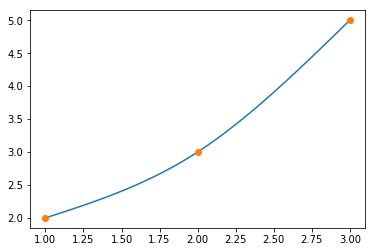

In [7]:
xinterp = np.linspace(1,3,100);

S = 0
for j in range(0,np.size(xvals)-1):
    S_j = 0
    for k in range(0,4):
        S_j += SCoeffs[k,j]*((xinterp-xvals[j])**k)
        
    if j==np.size(xvals)-2:
        mask = (xinterp>=xvals[j])*(xinterp<=xvals[j+1]);
    else:
        mask = (xinterp>=xvals[j])*(xinterp<xvals[j+1]);
    S += S_j*mask

plt.plot(xinterp,S)
plt.plot(xvals,yvals,'o')

plt.show()